In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn import ensemble, model_selection, preprocessing, tree
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import KFold

%matplotlib inline

In [6]:
col_names = []
q_vars = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
        'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
         'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

wilderness_areas = [1,2,3,4]
soil_types = [2702,2703,2704,2705,2706,2717,3501,3502,4201,4703,4704,4744,4758,5101,5151,6101,6102,6731,7101,7102,7103,7201,7202,7700,7701,7702,7709,7710,7745,7746,7755,7756,7757,7790,8703,8707,8708,8771,8772,8776]

col_names.extend(q_vars)
col_names.extend(wilderness_areas)
col_names.extend(soil_types)

col_names.append('Cover_Type')

I had to create the list of the column names.

In [7]:
dataset = pd.read_csv('covtype.data', names=col_names)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation                             581012 non-null int64
Aspect                                581012 non-null int64
Slope                                 581012 non-null int64
Horizontal_Distance_To_Hydrology      581012 non-null int64
Vertical_Distance_To_Hydrology        581012 non-null int64
Horizontal_Distance_To_Roadways       581012 non-null int64
Hillshade_9am                         581012 non-null int64
Hillshade_Noon                        581012 non-null int64
Hillshade_3pm                         581012 non-null int64
Horizontal_Distance_To_Fire_Points    581012 non-null int64
1                                     581012 non-null int64
2                                     581012 non-null int64
3                                     581012 non-null int64
4                                     581012 non-null int64
2702                                  581012 non-

There is no null values. In order to explore the categorical variables, we have to get them back from the dummies.

In [20]:
exploring_dataset = dataset.copy()
wilderness_area_cat = exploring_dataset[wilderness_areas].stack(-1)
wilderness_area_cat = wilderness_area_cat.where(wilderness_area_cat == 1).dropna()
exploring_dataset['Wilderness_Area'] = wilderness_area_cat.reset_index()['level_1']
exploring_dataset.drop(wilderness_areas, inplace=True, axis=1)

soil_types_cat = exploring_dataset[soil_types].stack(-1)
soil_types_cat = soil_types_cat.where(soil_types_cat == 1).dropna()
exploring_dataset['Soil_Type'] = soil_types_cat.reset_index()['level_1']
exploring_dataset.drop(soil_types, inplace=True, axis=1)

exploring_dataset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Wilderness_Area,Soil_Type
0,2596,51,3,258,0,510,221,232,148,6279,5,1,7745
1,2590,56,2,212,-6,390,220,235,151,6225,5,1,7745
2,2804,139,9,268,65,3180,234,238,135,6121,2,1,4744
3,2785,155,18,242,118,3090,238,238,122,6211,2,1,7746
4,2595,45,2,153,-1,391,220,234,150,6172,5,1,7745


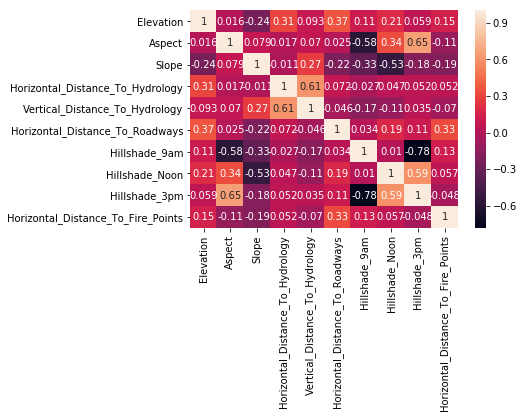

In [10]:
sns.heatmap(exploring_dataset[q_vars].corr(), annot=True)

There is not a high level of correlation between the variables. If some value were close to 1, I would choose one 
or the other but not both variables.

First explore quantitative variables. I will use violin plots so I can see the complete distribution and also
its quartiles.

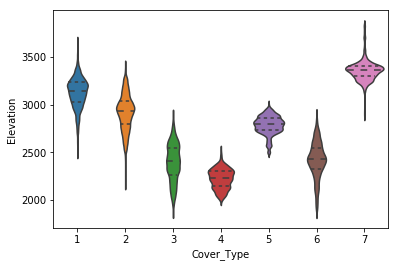

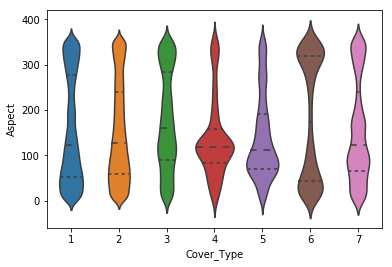

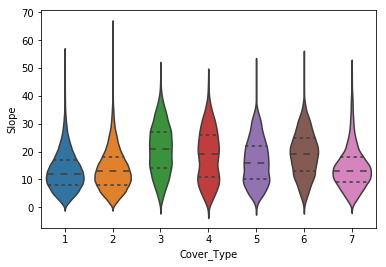

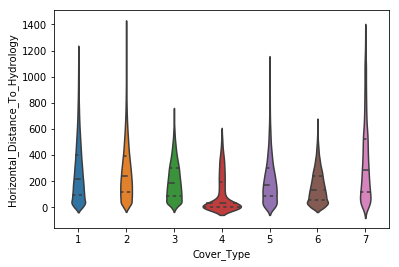

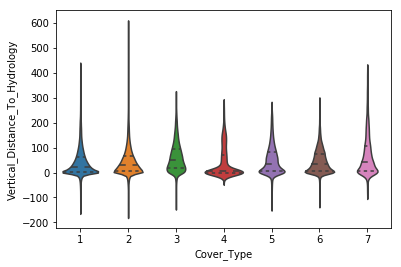

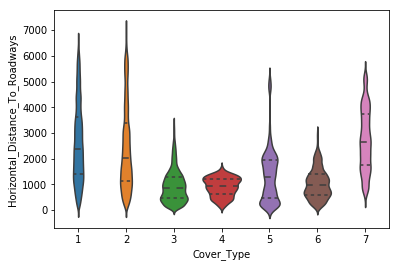

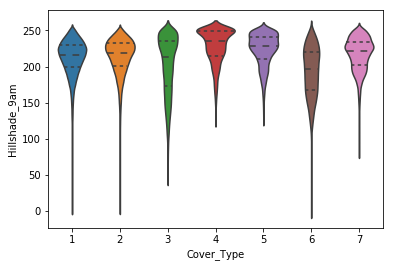

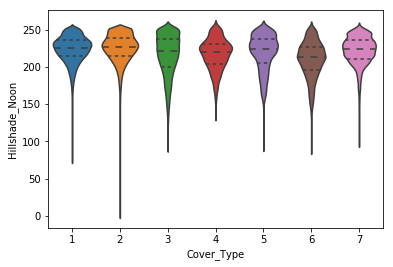

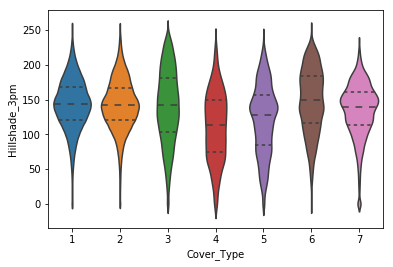

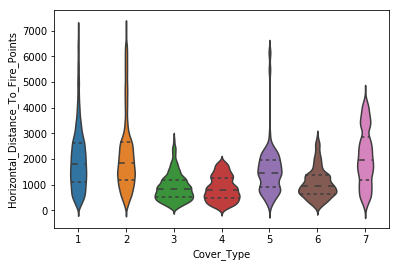

In [11]:
for q_var in q_vars:
    sns.violinplot(x='Cover_Type', y=q_var, data = exploring_dataset,  inner="quart")
    plt.show()

Elevation looks like a great variable. It separates the classes in 3 groups. The rest of the variables by itself are not separating cover_types but maybe they could do it with more dimensions.

Lets analyze categorical variables.

In [12]:
pd.crosstab([exploring_dataset['Wilderness_Area'], exploring_dataset['Soil_Type']],
            exploring_dataset['Cover_Type'],normalize=True).style.background_gradient(cmap='summer_r')

Sometimes an area has some particular soil types that are not in the other areas. This could help us separate the clases considering the rest of the features.

There is no reason not to include all the features in our model.

In [13]:
features = [cn for cn in col_names if cn not in ['Cover_Type']]
y = dataset['Cover_Type']
X = dataset[features]

In [14]:
splits = 10

kf = KFold(n_splits = splits, random_state=42)

train_results = []
test_results = []
importances = np.array([0.0 for i in range(X.shape[1])])
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train a random forest classifier
    rf = ensemble.RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    importances += rf.feature_importances_ 
    
    # make predictions for testing set
    # calculate testing accuracy
    train_results.append(rf.score(X_train, y_train))
    test_results.append(rf.score(X_test, y_test))

In [15]:
top_feature_importances = pd.Series(importances/splits).nlargest(5)
important_feature_names = X.columns[top_feature_importances.index]
top_feature_importances.index = important_feature_names
top_feature_importances

Elevation                             0.243106
Horizontal_Distance_To_Roadways       0.119462
Horizontal_Distance_To_Fire_Points    0.114412
Horizontal_Distance_To_Hydrology      0.060495
Vertical_Distance_To_Hydrology        0.057079
dtype: float64

Here we can see the top 5 features of the model without limiting the maximum depth.
Our initial guess about Elevation was correct.

In [16]:
train_results = np.array(train_results)
test_results = np.array(test_results)
print(train_results.mean(), test_results.mean())

0.99805511763 0.728038095605


Such a high accuracy score in average of the 10 folds in the training set and a big difference compared to the test set may indicate overfitting. To prevent this I will limit the depth of the trees in the random forest.

In [17]:
splits = 10

kf = KFold(n_splits = splits, random_state=42)

train_results = []
test_results = []
importances = np.array([0.0 for i in range(X.shape[1])])
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train a random forest classifier
    rf = ensemble.RandomForestClassifier(random_state=42, max_depth=20)
    rf.fit(X_train, y_train)
    importances += rf.feature_importances_ 
    
    # make predictions for testing set
    # calculate testing accuracy
    train_results.append(rf.score(X_train, y_train))
    test_results.append(rf.score(X_test, y_test))

In [18]:
top_feature_importances = pd.Series(importances/splits).nlargest(5)
important_feature_names = X.columns[top_feature_importances.index]
top_feature_importances.index = important_feature_names
top_feature_importances

Elevation                             0.291524
Horizontal_Distance_To_Roadways       0.104037
Horizontal_Distance_To_Fire_Points    0.092916
Horizontal_Distance_To_Hydrology      0.046401
Vertical_Distance_To_Hydrology        0.041532
dtype: float64

In [19]:
train_results = np.array(train_results)
test_results = np.array(test_results)
print("Train: ", train_results.mean(),"Test: " ,test_results.mean())

Train:  0.91676706447 Test:  0.724342732932


The accuracy in the test set did not go up with the max_depth=20, but the training set is no longer overfitted by the model (At least not like it was before). 

I picked up this model because I wanted to know which of the features were the most important to consider if I wanted to continue investigating about the same problem. Also it is easier to explain the results to someone who is not related with Data Science directly. 

The solution (in spanish) of the other two problems is here: https://docs.google.com/document/d/1i2HHEeHOaNTtZdKDPbImLNo8RLTq4k9CIaRQX4kM3U0/editm